In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam

In [16]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

batch_size = 128

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


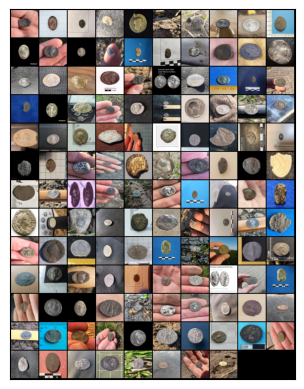

In [4]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [64]:
n_channels = 3 # RGB

class D(nn.Module):
    def __init__(
        self,
        hyperparams: dict 
    ): 
        super(D, self).__init__()

        num_layers = hyperparams['num_layers']
        kernel_size = hyperparams['kernel_size']
        padding = hyperparams['padding']
        stride = hyperparams['stride']
        ndf = hyperparams['ndf']

        final_in_channel = 0 
        final_out_channel = 0 
        final_kernel_size = 0
        final_stride = 0
        
        self.layers = nn.ModuleList() 

        # Dynamically add more layers 
        for i in range(num_layers):
            in_channels = n_channels if i == 0 else hyperparams['ndf'][i - 1]            
            out_channels = hyperparams['ndf'][i]
            kernel_size = hyperparams['kernel_size'][i]
            stride = hyperparams['stride'][i]
            padding = hyperparams['padding'][i]
            self.layers.append(
                nn.Conv2d(
                    in_channels = in_channels,
                    out_channels = out_channels,
                    kernel_size = kernel_size,
                    padding = padding,
                    stride = stride,
                    bias = False
                )
            )
            self.layers.append(
                nn.BatchNorm2d(
                    out_channels
                )
            )
            self.layers.append(
                nn.LeakyReLU(
                    inplace = True, 
                    negative_slope = 0.2 # TODO: MIGHT ADD TO HYPERPARAMETERS! 
                )
            )
            # For the last layer
            final_channel = out_channels
            final_kernel = kernel_size
            final_stride = stride
            final_padding = padding

        # Add final layer 
        self.layers.append(
            nn.Conv2d(
                in_channels = final_channel,
                out_channels = 1, # Final feature map
                kernel_size = final_kernel,
                padding = final_padding,
                stride = final_stride,
                bias = False
            )
        )

        self.layers.append(
            nn.Flatten()  # Flatten the feature map before the linear layer
        )

        self.layers.append(
            # Init Linear layer
            nn.Linear(in_features = None, out_features = 1, bias = False)
        )
        
        self.layers.append(
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                self.linear_layer_size = x.size()[1:].numel()  # Exclude batch dimension and return the computed: height * width * channel as a single vector i.e. flattened dimension size for Linear layer
                print("LINEAR LAYER SIZE", self.linear_layer_size)
                self.linear_layer = nn.Linear(in_features = self.linear_layer_size, out_features = 1, bias = False)
        return x



class G(nn.Module):
    def __init__(
        self,
        hyperparams: dict
    ): 
        super(G, self).__init__()

        latent_size = hyperparams['nz']
        num_feature_maps = hyperparams['ngf']
        
        self.layers = nn.ModuleList() 
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_size, num_feature_maps * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(num_feature_maps * 8),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(num_feature_maps * 8, num_feature_maps * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(inplace = True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(num_feature_maps, n_channels, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )        

    def forward(self, x):
        print(self.main(input).shape)
        return x 


In [65]:
def evaluate_performance(d_model, g_model):
    return 1.


In [66]:
num_epochs = 0
real_label = 1 
fake_label = 0 

D_losses = []
G_losses = []

img_list = []
iters = 0

best_score = float('-inf')
best_hyperparams = None
best_general_hyperparams = None

criterion = nn.BCELoss()

hyperparameters_G = {
    'nz': [50, 100, 150, 200],  # Size of latent space vector 
    'lr': [round(i * 0.0001, 10) for i in range(1, 100)],  # Between 0.0001 and 0.0999
}

hyperparameters_D = {
    'ndf': list(range(32, 128)),  # Number of feature maps in discriminator
    'lr': [round(i * 0.0001, 15) for i in range(1, 100)],  
    'kernel_size': [1, 2, 3, 4],  
    'padding': [0, 1, 2],  
    'stride': [1, 2, 3], 
    'num_layers' : [1, 2, 3, 4, 5]
}

general_hyperparameters = {
    'batch_size': [32, 64, 128, 256],
    'num_epochs': [20, 30, 50, 75, 100],
    'image_size': 64 # Image size NxN
}  

# Generator feature maps 
def generate_ngf() -> int:
    min_ngf = 32
    max_ngf = 128
    return random.randint(min_ngf, max_ngf) 

# Discriminator feature maps 
def generate_ndf_list(num_layers, initial_ndf, max_ndf):
    ndf_list = [initial_ndf]
    for _ in range(1, num_layers):
        new_ndf = random.randint(ndf_list[-1], max_ndf)
        ndf_list.append(new_ndf)
    return ndf_list


for _ in range(trials):
    sampled_hyperparams_general = {
        'batch_size': random.choice(general_hyperparameters['batch_size']),
        'num_epochs': random.choice(general_hyperparameters['num_epochs']),
        'image_size': general_hyperparameters['image_size']
    }

    # Debug
    print("IMAGE SIZE: ", sampled_hyperparams_general['image_size'])
    print("num_epochs: ", sampled_hyperparams_general['num_epochs'])
    print("batch_size: ", sampled_hyperparams_general['batch_size'])

    data_loader_rs = DataLoader(
        dataset, 
        sampled_hyperparams_general['batch_size'], 
        shuffle = True
    )

    # Discriminator only ---
    # Get number of feature maps
    num_layers = random.choice(hyperparameters_D['num_layers']) 
    initial_ndf = random.choice(hyperparameters_D['ndf'])  
    max_ndf = max(hyperparameters_D['ndf'])  
    ndf_list = generate_ndf_list(num_layers, initial_ndf, max_ndf)
    print("List of ndf values for each layer:", ndf_list) # Debug
    
    sampled_hyperparams_D = {
        'ndf': ndf_list, 
        'lr': random.choice(hyperparameters_D['lr']),    
        'kernel_size': [random.choice(hyperparameters_D['kernel_size']) for _ in range(num_layers)],  
        'padding': [random.choice(hyperparameters_D['padding']) for _ in range(num_layers)],         
        'stride': [random.choice(hyperparameters_D['stride']) for _ in range(num_layers)],          
        'num_layers': num_layers  
    }
    # ---

    sampled_hyperparams_G = {
        'nz': random.choice(hyperparameters_G['nz']),
        'ngf': generate_ngf(), 
        'lr': random.choice(hyperparameters_G['lr'])
    }
    
    num_epochs = sampled_hyperparams_general['num_epochs']
    batch_size = sampled_hyperparams_general['batch_size']
    
    fixed_noise = torch.randn(sampled_hyperparams_general['image_size'], sampled_hyperparams_G['nz'], 1, 1, device = device) 
    
    d_model = D(sampled_hyperparams_D) 
    g_model = G(hyperparams = sampled_hyperparams_G)
    d_model.to(device)
    g_model.to(device)

    optimizer_d = Adam(d_model.parameters(), lr = sampled_hyperparams_D['lr'])
    optimizer_g = Adam(g_model.parameters(), lr = sampled_hyperparams_G['lr'])

    for epoch in range(num_epochs): # Random? 
        for i, data in enumerate(data_loader_rs, 0): 
            # Train discriminator with real images
            d_model.zero_grad()
            real_device = data[0].to(device)
            b_size = real_device.size(0) # Real batch size 
            label = torch.full((b_size,), real_label, dtype = torch.float, device = device) # Fill the batch with real_labels i.e. 1
            label = label.view(-1) 
            # Forward 
            output = d_model(real_device)
    
            print(f"OUTPUT D: {output.shape}")
            print(f"LABEL: {label.shape}")
            
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item() # Mean output from model for each batch

            # Train discriminator with fake images 
            latent = torch.randn(b_size, sampled_hyperparams_G['nz'], 1, 1, device = device) # Create the latent vector with count(b_size) and dynamic size  
            fake = g_model(latent) # Feed latent vector sample to generator 
            label.fill_(fake_label) # Replace all labels with fake label
            output = d_model(fake.detach()).view(-1) # Feed and forget the fake image (detach) from the computational tree then Flatten output 
            errD_fake = criterion(output, label)
            errD_fake.backward() 
            D_G_z1 = output.mean().item() # The output from the discriminator based on fake images made by the generator (D_G_z1 -> D(G(z1)))
            errD = errD_real + errD_fake # Compute the total error for the discriminator over real and fake runs 
            optimizer_d.step()

            # Train the generator 
            g_model.zero_grad() 
            label.fill_(real_label) # fake labels are real for generator cost
            output = d_model(fake).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D (d_model)
            errG = criterion(output, label) # Calculate G's loss based on this output
            errG.backward()
            D_G_z2 = output.mean().item() # Same as (D_G_z1 -> D(G(z1)))
            optimizer_g.step()

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Output training stats
            if i % 50 == 0: # Run for every 50 iteration 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(data_loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
                with torch.no_grad():
                    fake = g_model(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
    
            iters += 1

    # Min/Max Check
    score = evaluate_performance(d_model, g_model) # TODO: FINISH!

    # Update best score model
    if score > best_score:
        best_score = score
        best_hyperparams = sampled_hyperparams # TODO: FOR EACH MODEL (D AND G) 
        best_general_hyperparams = sampled_hyperparams_general

print("Best hyperparameters:", best_hyperparams)


# TODO: STOP THE TRAINING WHEN THE RESULTS WONT GET BETTER - EXIT CRITERIA

IMAGE SIZE:  64
num_epochs:  75
batch_size:  256
List of ndf values for each layer: [92]


TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got NoneType"